<center>
    <img src="https://gitlab.com/ibm/skills-network/courses/placeholder101/-/raw/master/labs/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


***


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [63]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

This function is to plot the confusion matrix.


In [65]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

## Load the dataframe


Load the data


In [66]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

# data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_2.csv')

data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [67]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

# X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_3.csv')

X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [68]:
Y = data['Class']
type(Y)

pandas.core.series.Series

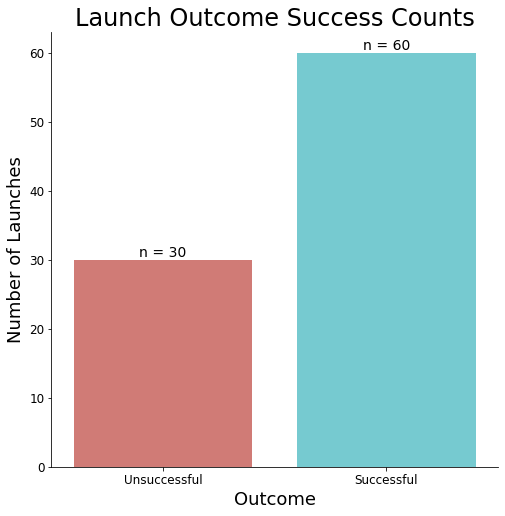

In [69]:
df=Y.value_counts()
plt.figure(figsize=(8,8))
ax=sns.barplot(x=df.index, y=df.values, palette='hls', alpha=0.9)
sns.despine(top=True, right=True, left=False, bottom=False)
for p in ax.patches:
    ax.annotate('n = {:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()), 
                ha='center', va='bottom', color='black', fontsize=14)
ax.set_xticklabels(['Unsuccessful', 'Successful'], minor=False, fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Launch Outcome Success Counts', fontsize=24)
plt.ylabel('Number of Launches',fontsize=18)
plt.xlabel('Outcome',fontsize=18)
plt.show()

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [70]:
# students get this 
transform = preprocessing.StandardScaler()

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [72]:
X_train.shape

(72, 83)

In [73]:
X_test.shape

(18, 83)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [74]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

we can see we only have 18 test samples.


In [75]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [76]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [77]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10, refit=True)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [78]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [79]:
from sklearn.metrics import roc_auc_score
glm_acc=logreg_cv.score(X_test, Y_test)
print("Test set accuracy: {:.1%}".format(glm_acc))
glm_probs = logreg_cv.predict_proba(X_test)[:,1]
try:
    glm_auc=roc_auc_score(Y_test, glm_probs) 
    print("Test set AUC: {:.3}".format(glm_auc))
except ValueError:
    pass

Test set accuracy: 83.3%
Test set AUC: 0.889


Lets look at the confusion matrix:


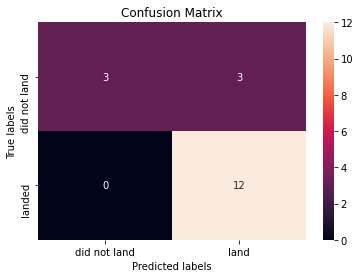

In [80]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


In [103]:
# Compute confusion matrix
glm_yhat = logreg_cv.predict(X_test)
glm_f1 = f1_score(Y_test, glm_yhat) 
glm_prec = precision_score(Y_test, glm_yhat)
glm_rec = recall_score(Y_test, glm_yhat) 
cnf_matrix = confusion_matrix(Y_test, glm_yhat, labels=[1,0])
np.set_printoptions(precision=2)
print(classification_report(Y_test, glm_yhat))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Landed', 'Did not land'], normalize= False, title='GLM Confusion matrix')

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



TypeError: plot_confusion_matrix() got an unexpected keyword argument 'classes'

<Figure size 576x432 with 0 Axes>

## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [85]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC(probability=True, random_state=1)

In [86]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(probability=True, random_state=1),
             param_grid={'C': array([1.00e-03, 3.16e-02, 1.00e+00, 3.16e+01, 1.00e+03]),
                         'gamma': array([1.00e-03, 3.16e-02, 1.00e+00, 3.16e+01, 1.00e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [87]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [88]:
svm_acc=svm_cv.score(X_test, Y_test)
print("Test set accuracy: {:.1%}".format(svm_acc))
svm_probs = svm_cv.predict_proba(X_test)[:,1]
svm_auc=roc_auc_score(Y_test, svm_probs) 
print("Test set AUC: {:.3}".format(svm_auc))

Test set accuracy: 83.3%
Test set AUC: 0.958


We can plot the confusion matrix


In [89]:
# Compute confusion matrix
svm_yhat = svm_cv.predict(X_test)
svm_f1 = f1_score(Y_test, svm_yhat) 
svm_prec = precision_score(Y_test, svm_yhat)
svm_rec = recall_score(Y_test, svm_yhat) 
cnf_matrix = confusion_matrix(Y_test, svm_yhat, labels=[1,0])
np.set_printoptions(precision=2)
print(classification_report(Y_test, svm_yhat))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Landed', 'Did not land'], normalize=False, title='SVM Confusion matrix')

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



TypeError: plot_confusion_matrix() got an unexpected keyword argument 'classes'

<Figure size 576x432 with 0 Axes>

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [91]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier(random_state=1)

In [93]:
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [94]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
accuracy : 0.8357142857142857


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [95]:
tree_acc=tree_cv.score(X_test, Y_test)
print("Test set accuracy: {:.1%}".format(tree_acc))
tree_probs = tree_cv.predict_proba(X_test)[:,1]
tree_auc=roc_auc_score(Y_test, tree_probs) 
print("Test set AUC: {:.3}".format(tree_auc))

Test set accuracy: 77.8%
Test set AUC: 0.792


We can plot the confusion matrix


In [96]:
# Compute confusion matrix
tree_yhat = tree_cv.predict(X_test)
tree_f1 = f1_score(Y_test, tree_yhat) 
tree_prec = precision_score(Y_test, tree_yhat)
tree_rec = recall_score(Y_test, tree_yhat) 
cnf_matrix = confusion_matrix(Y_test, tree_yhat, labels=[1,0])
np.set_printoptions(precision=2)
print(classification_report(Y_test, tree_yhat))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Landed', 'Did not land'], normalize=False, title='Decision Tree Confusion matrix')

              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.90      0.75      0.82        12

    accuracy                           0.78        18
   macro avg       0.76      0.79      0.77        18
weighted avg       0.81      0.78      0.78        18



TypeError: plot_confusion_matrix() got an unexpected keyword argument 'classes'

<Figure size 576x432 with 0 Axes>

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [97]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [98]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [99]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [100]:
knn_acc = knn_cv.score(X_test, Y_test)
print("Test set accuracy: {:.1%}".format(knn_acc))
knn_probs = knn_cv.predict_proba(X_test)[:,1]
knn_auc=roc_auc_score(Y_test, knn_probs) 
print("Test set AUC: {:.3}".format(knn_auc))

Test set accuracy: 83.3%
Test set AUC: 0.847


We can plot the confusion matrix


In [101]:
# Compute confusion matrix
knn_yhat = knn_cv.predict(X_test)
knn_f1 = f1_score(Y_test, knn_yhat) 
knn_prec = precision_score(Y_test, knn_yhat)
knn_rec = recall_score(Y_test, knn_yhat) 
cnf_matrix = confusion_matrix(Y_test, knn_yhat, labels=[1,0])
np.set_printoptions(precision=2)
print(classification_report(Y_test, knn_yhat))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Landed', 'Did not land'], normalize=False, title='KNN Confusion matrix')

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



TypeError: plot_confusion_matrix() got an unexpected keyword argument 'classes'

<Figure size 576x432 with 0 Axes>

## TASK  12


Find the method performs best:


In [102]:
data = {'AUC': [glm_auc, svm_auc, tree_auc, knn_auc], 'F1-Score': [glm_f1, svm_f1, tree_f1, knn_f1], 
        'Precision': [glm_prec, svm_prec, tree_prec, knn_prec], 'Recall': [glm_rec, svm_rec, tree_rec, knn_rec],
        'Accuracy': [glm_acc, svm_acc, tree_acc, knn_acc]}
res = pd.DataFrame(data, index=['Logistic Regression', 'SVM', 'Decision Tree', 'KNN']).sort_values(by=['AUC'], ascending=False)
res.round(3)

,AUC,F1-Score,Precision,Recall,Accuracy
SVM,0.958,0.889,0.8,1.00,0.833
Logistic Regression,0.889,0.889,0.8,1.00,0.833
KNN,0.847,0.889,0.8,1.00,0.833
Decision Tree,0.792,0.818,0.9,0.75,0.778


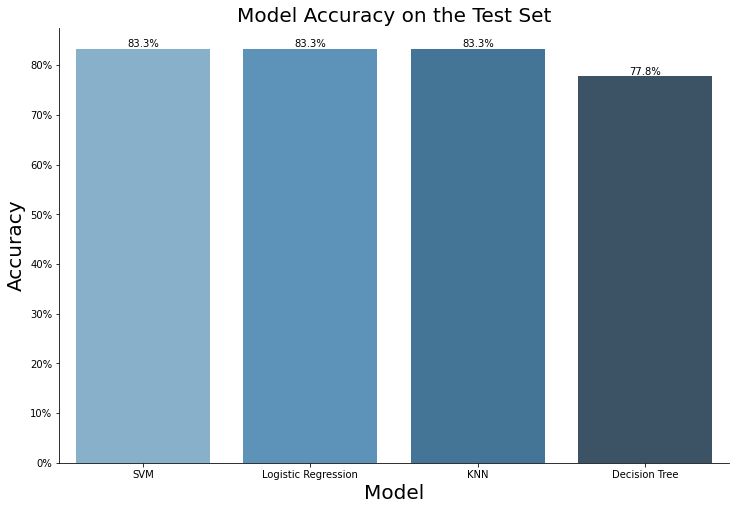

In [104]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x=res.index, y='Accuracy', data=res, palette='Blues_d')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Model', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x*100)))
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()*100), (p.get_x()+0.4, p.get_height()), 
                ha='center', va='bottom',color= 'black')
plt.title('Model Accuracy on the Test Set', fontsize=20)
plt.show()

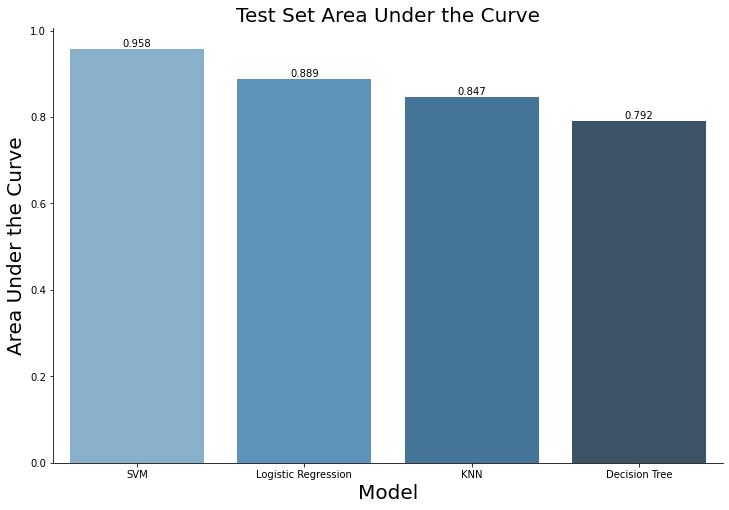

In [105]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x=res.index, y='AUC', data=res, palette='Blues_d')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Model', fontsize=20)
plt.ylabel('Area Under the Curve', fontsize=20)
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()), 
                ha='center', va='bottom',color='black')
plt.title('Test Set Area Under the Curve', fontsize=20)
plt.show()

## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2021-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By    | Change Description      |
| ----------------- | ------- | ------------- | ----------------------- |
| 2021-08-31        | 1.1     | Lakshmi Holla | Modified markdown       |
| 2020-09-20        | 1.0     | Joseph        | Modified Multiple Areas |


Copyright © 2020 IBM Corporation. All rights reserved.
